# Index constituent returns

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

equities <- EquitiesIndiaNse()
indices <- Indices()

In [40]:
indexName <- "NIFTY 100"
startDate <- as.Date("2018-01-01")
endDate <- as.Date("2019-11-25")

In [41]:
constitutents <- indices$NseConstituents() %>%
        filter(NAME == indexName) %>%
        select(SYMBOL, CAP_WEIGHT) %>%
        collect() %>%
        as.data.frame()

In [42]:
constitutents$S_DATE <- NA
constitutents$E_DATE <- NA
constitutents$RETURNS_CUM <- NA

In [43]:
#nrow(constitutents)
for(i in 1:nrow(constitutents)){
    if(!is.na(constitutents$RETURNS_CUM[i])){
        next
    }
    
    sym <- toString(constitutents$SYMBOL[i])
    
    tryCatch({
        pxDf <- equities$EodAdjustedTimeSeries() %>%
            filter(SYMBOL == sym & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
            select(TIME_STAMP, CLOSE) %>%
            collect() %>%
            mutate(TIME_STAMP = as.Date(TIME_STAMP))

        pxXts <- xts(pxDf$CLOSE, pxDf$TIME_STAMP)

        constitutents$RETURNS_CUM[i] <- 100*as.numeric(Return.cumulative(dailyReturn(pxXts)))
        constitutents$S_DATE[i] <- toString(first(index(pxXts)))
        constitutents$E_DATE[i] <- toString(last(index(pxXts)))
    }, error=function(e){
        print(sym)
        print(e)
    })
}

In [44]:
print(constitutents[order(constitutents$RETURNS_CUM, decreasing=T),])

        SYMBOL CAP_WEIGHT     S_DATE     E_DATE RETURNS_CUM
11  BAJFINANCE     1.7309 2018-01-01 2019-11-25  140.842020
38     HDFCAMC     0.2107 2018-08-06 2019-11-25  100.427261
67   NESTLEIND     0.9108 2018-01-01 2019-11-25   89.550813
14  BERGEPAINT     0.2110 2018-01-01 2019-11-25   84.312988
9   BAJAJFINSV     0.9378 2018-01-01 2019-11-25   77.512503
82    RELIANCE     8.9355 2018-01-01 2019-11-25   73.659920
48     ICICIGI     0.3777 2018-01-01 2019-11-25   73.173836
91         TCS     3.9893 2018-01-01 2019-11-25   66.713388
26    DIVISLAB     0.3898 2018-01-01 2019-11-25   63.466617
47   ICICIBANK     5.5475 2018-01-01 2019-11-25   61.531597
58   KOTAKBANK     3.7583 2018-01-01 2019-11-25   60.541596
92       TECHM     0.8284 2018-01-01 2019-11-25   58.569129
44  HINDUNILVR     2.6469 2018-01-01 2019-11-25   57.462160
28       DMART     0.3571 2018-01-01 2019-11-25   56.997010
40    HDFCLIFE     0.5249 2018-01-01 2019-11-25   54.101953
5   ASIANPAINT     1.4036 2018-01-01 201

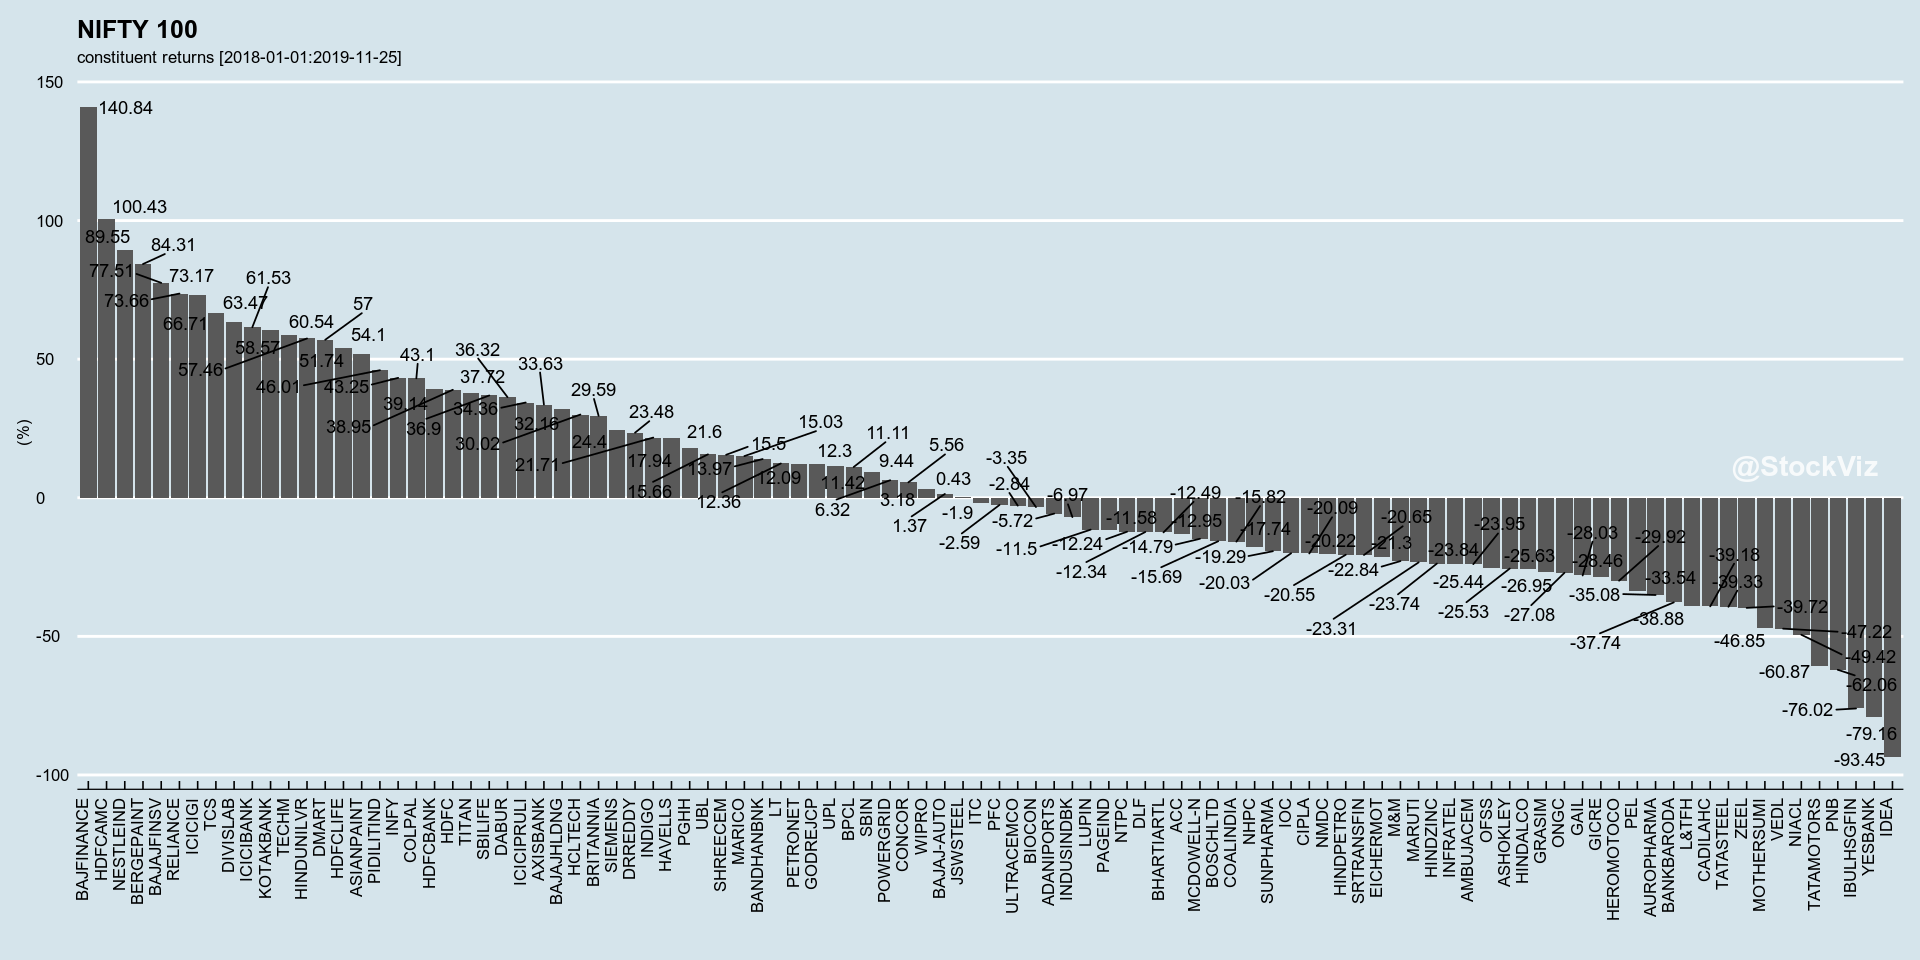

In [45]:
mDf <- constitutents[,c('SYMBOL', 'RETURNS_CUM')]
#mDf$SYMBOL <- factor(mDf$SYMBOL)

ggplot(mDf, aes(x=reorder(SYMBOL, -RETURNS_CUM), y=RETURNS_CUM)) +
    theme_economist() +
    theme(axis.text.x=element_text(angle=90, hjust=1)) +
    geom_bar(stat="identity", position=position_dodge()) +
    geom_text_repel(aes(label= round(RETURNS_CUM, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=indexName, subtitle=sprintf("constituent returns [%s:%s]", startDate, endDate)) +
    annotate("text", x=nrow(mDf), y=0, 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

In [46]:
iPx <- indices$NseTimeSeries() %>%
    filter(NAME == indexName & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(CLOSE, TIME_STAMP) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

iPxXts <- xts(iPx$CLOSE, iPx$TIME_STAMP)
iDret <- dailyReturn(iPxXts)

In [48]:
print(100*Return.cumulative(iDret))

                  daily.returns
Cumulative Return      11.88227


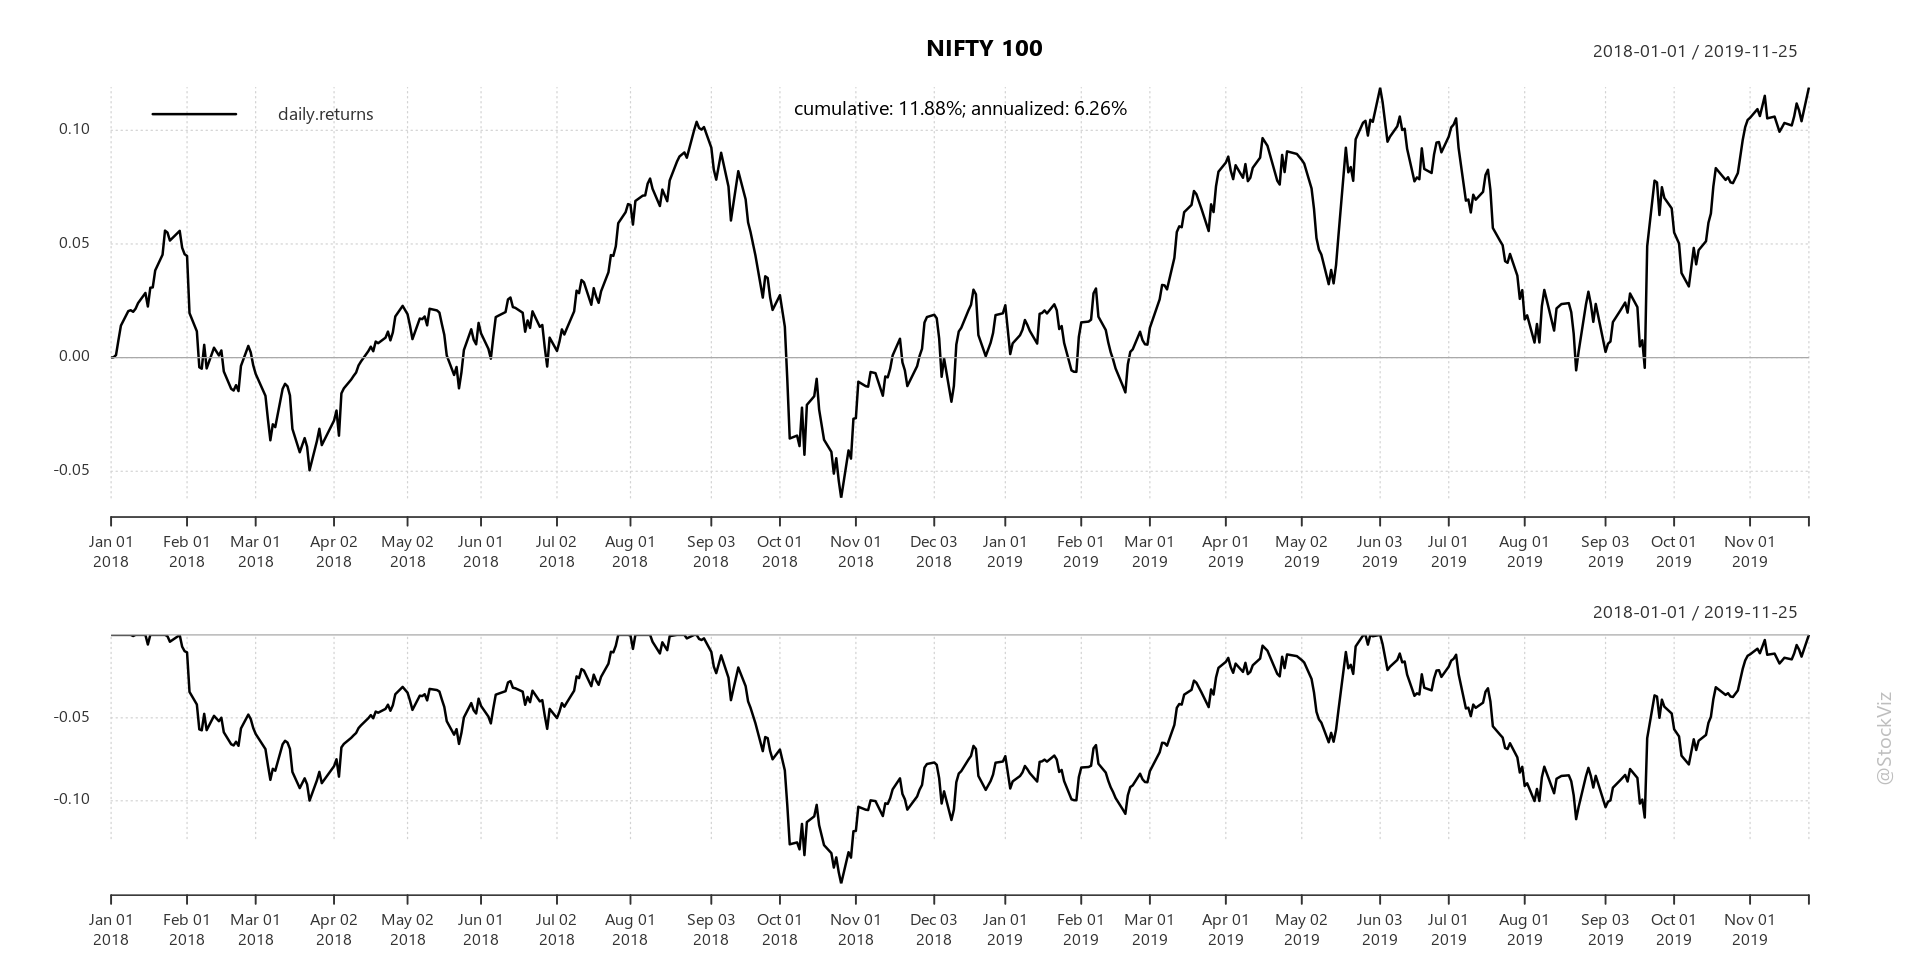

In [49]:
Common.PlotCumReturns(iDret, indexName, "")

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!